In [100]:
import pyaudio
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display, clear_output
import librosa
import os
import pandas as pd
import sounddevice as sd
from scipy.signal import chirp
import threading


In [101]:
CHANNELS = 1
SR = 48000 # Sample rate in Hz
FORMAT = pyaudio.paFloat32  # 16-bit audio format
AMPLIFICATION_FACTOR = 10**(47 / 20)  # Convert 47 dB to linear scale
CHUNK = 4096# 4096*4 # Number of frames per buffer

In [102]:
SOUNDS = {
    "sweep": chirp(np.linspace(0, 1, SR), f0=100, f1=10000, t1=1, method='linear').astype('float32'),
    "white_noise": np.random.uniform(low=-0.999, high=1.0, size=(SR)).astype('float32'),
    "silence": np.zeros((SR,), dtype='float32'),
}

In [103]:
init_dur = 0.001  # Duration in seconds
init_freq = 2000  # Frequency of the tone in Hz
t = np.linspace(0, init_dur, int(SR * init_dur), endpoint=False)

init_tone = np.sin(2 * np.pi * init_freq * t).astype('float32')
init_pad = np.zeros((SR,), dtype='float32')

# plt.figure(figsize=(30, 5))
# plt.plot(init_tone)

In [104]:
duration = 0.1  # Duration in seconds
frequency1 = 1000  # Frequency of the tone in Hz
frequency2 = 5000  # Frequency of the tone in Hz

# Generate time vector
t = np.linspace(0, duration, int(SR * duration), endpoint=False)

# Generate the sinusoidal tone
tone1 = np.sin(2 * np.pi * frequency1 * t).astype('float32')
tone2 = np.sin(2 * np.pi * frequency2 * t).astype('float32')
# sound = np.hstack([init_tone, tone1, tone2, init_tone])
sound = np.hstack([init_pad, init_tone, init_pad, tone1, init_pad, init_tone, init_pad])

In [105]:
audio = pyaudio.PyAudio()
input_device_index = None
output_device_index = None

for i in range(audio.get_device_count()):
    device_info = audio.get_device_info_by_index(i)
    
    if (not input_device_index and "MAYA44USB" in device_info['name'] and "Ch12" in device_info['name'] and 
        device_info['maxInputChannels'] == 4):
        input_device_index = i
    if (not output_device_index and "MAYA44USB" in device_info['name'] and "Ch12" in device_info['name'] and 
        device_info['maxOutputChannels'] == 4):
        output_device_index = i
audio = pyaudio.PyAudio()
stream = audio.open(
    format=FORMAT,      #? they used paInt32 in the paper
    channels=CHANNELS,
    rate=SR,
    output=True,
    input=True,
    input_device_index=input_device_index,
    frames_per_buffer=CHUNK,
    output_device_index=output_device_index
)

global Ains
Ains = np.zeros_like(sound, dtype=np.float32)

start_event = threading.Event()

def playback():
    start_event.wait()  # Wait until both threads are ready
    stream.write(sound.tobytes())
def recording():
    global Ains
    frames = []
    start_event.wait()
    num_frames = int(len(sound) / CHUNK)
    for _ in range(num_frames):
        data = stream.read(CHUNK, exception_on_overflow=False)
        frames.append(np.frombuffer(data, dtype=np.float32))
    Ains = np.hstack(frames)

    if len(Ains) > len(sound):
        Ains = Ains[:len(sound)]
    elif len(Ains) < len(sound):
        Ains = np.pad(Ains, (0, len(sound) - len(Ains)), 'constant')

# Threads for simultaneous playback and recording
play_thread = threading.Thread(target=playback)
record_thread = threading.Thread(target=recording)

play_thread.start()
record_thread.start()

start_event.set()

# Wait for both threads to complete
play_thread.join()
record_thread.join()

stream.stop_stream()
stream.close()
audio.terminate()

In [106]:
Ains_norm = Ains / np.max(np.abs(Ains))

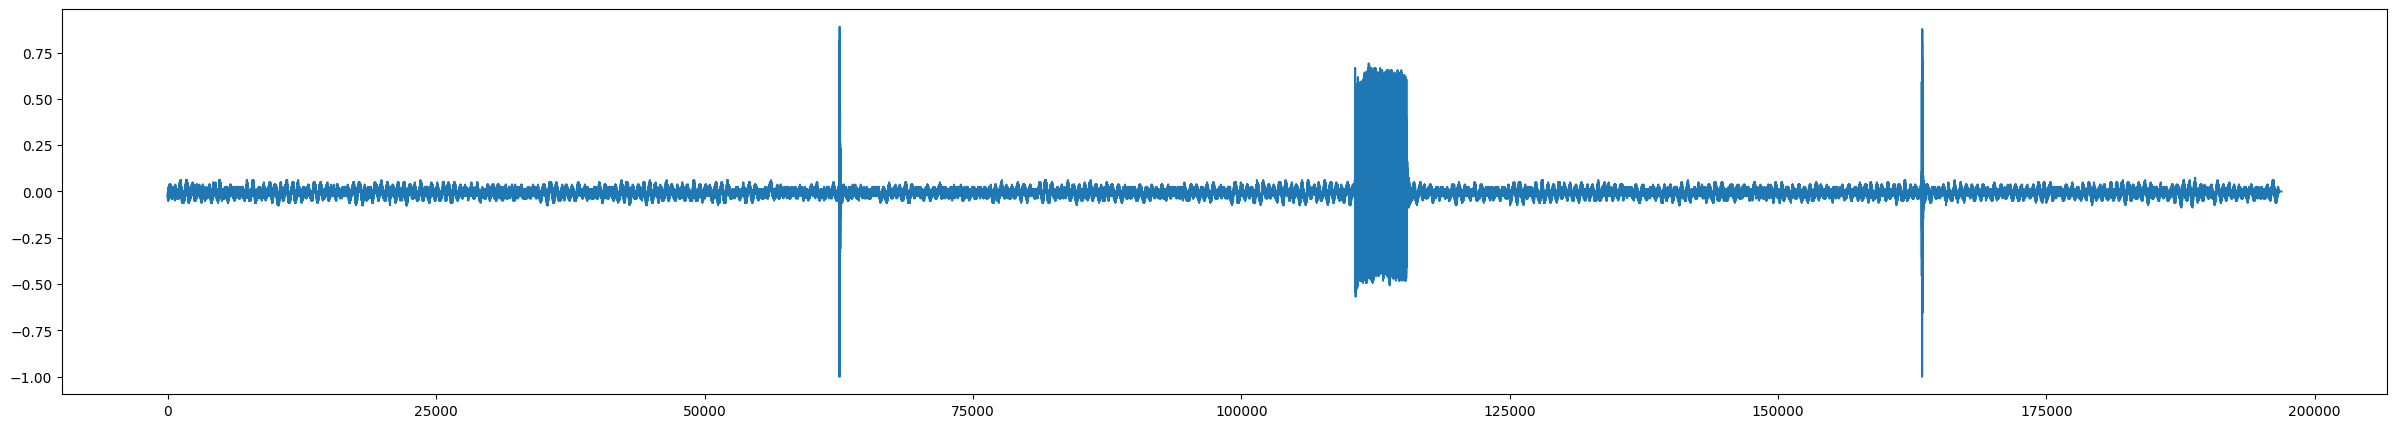

In [107]:
plt.figure(figsize=(30, 5))
plt.plot(Ains_norm)

In [1072]:
# Compute the FFT spectrum
Ains_spectrum = np.fft.rfft(Ains_norm)

# Extract amplitude (magnitude) and phase (angle)
Ains_amplitude = np.abs(Ains_spectrum)
Ains_phase = np.angle(Ains_spectrum)

# Compute frequency bins
Ains_frequency = np.fft.rfftfreq(len(Ains), 1/SR)

# Create a DataFrame with frequency, amplitude, and phase
Ains_series = pd.DataFrame({
    "Amplitude": Ains_amplitude,
    "Phase": Ains_phase
}, index=pd.Index(Ains_frequency, name="Frequency"))
Ains_series

,Amplitude,Phase
Frequency,,
0.000000,4337.937500,3.141593
0.344828,101.211224,0.894201
0.689655,229.490781,1.593021
1.034483,45.744561,-0.345539
1.379310,135.252834,-1.147511
...,...,...
23998.620690,10.617820,1.099085
23998.965517,16.098982,-2.405321
23999.310345,9.971789,1.143164


<Axes: title={'center': 'Frequency Spectrum'}, xlabel='Frequency (Hz)', ylabel='Amplitude'>

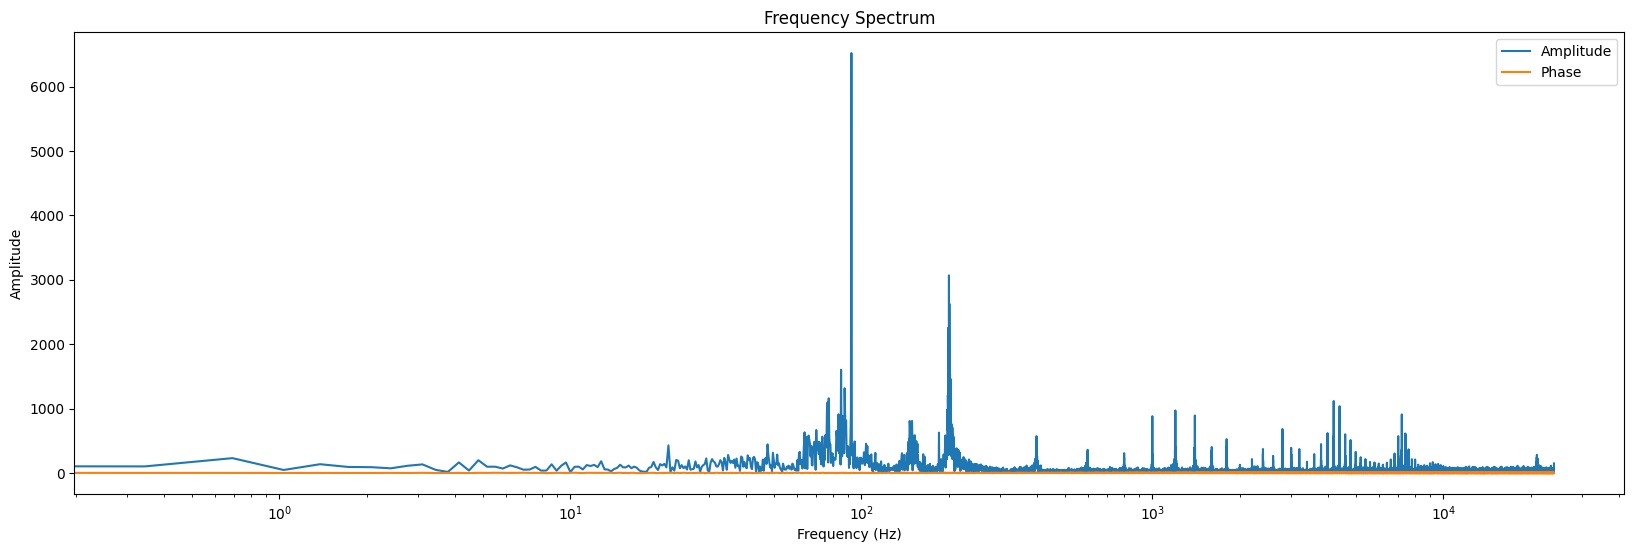

In [1074]:
Ains_series.plot(title="Frequency Spectrum", xlabel="Frequency (Hz)", ylabel="Amplitude", logy=False, logx=True, figsize=(20, 6))